Note too self, control_1 and Fmr1_4 are currently pretty much empty... for now. 

# Count Arrays for Greenblatt and Spradling D. Melanogaster data

This notebook contains a variety of code that allows me to create arrays of counts at each transcript position (nucleotide precision). 

Note that depending on the number of samples you are using, this notebook may use up a large amount of RAM (about 1 GB per sample). 

In [1]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, Transcript
import numpy as np

In [7]:
PATH = "/Users/keeganflanagan/Desktop/Khanh_position/genomes_and_samples/Fly/"

In [8]:
# load the transcript annotations from the GTF file.
# BED_Reader returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(PATH + "Drosophila_melanogaster.BDGP6.32.103.gtf"),return_type=Transcript))

In [45]:
maprule_Fmr1 = VariableFivePrimeMapFactory.from_file(open(PATH + "dmel_Fmr1_1_riboprofile_p_offsets.txt"))
maprule_control = VariableFivePrimeMapFactory.from_file(open(PATH + "dmel_control_2_riboprofile_p_offsets.txt"))

# load ribosome profiling data
alignments_Fmr1 = BAMGenomeArray(PATH + "dmel_Fmr1_RPF_1_Aligned.sortedByCoord.out.bam")
alignments_control = BAMGenomeArray(PATH + "dmel_control_RPF_2_Aligned.sortedByCoord.out.bam")

# set P-site mapping as 14 nucleotides from 5' end
alignments_Fmr1.set_mapping(maprule_Fmr1)
alignments_control.set_mapping(maprule_control)

---------------------------------------------------------------------------
UserWarning
Given offset '50' longer than read length '37'. Falling back to default '13'.
in /opt/anaconda3/envs/plastid/lib/python3.8/site-packages/plastid/util/services/exceptions.py, line 234:

232         filterwarnings("onceperfamily", message=pattern, category=category)
234     warn(message, category=category, stacklevel=stacklevel)

---------------------------------------------------------------------------


In [11]:
top_10 = ["CG17734", "Nf1", "Ctl2", "CG12517", "CG16974", "Pi3K92E", 
          "Prosap", "ctrip", "RpL34b", "ALiX"]

In [12]:
# create a list to hold the vectors
count_vectors_Fmr1 = []

# get counts for each transcript
for transcript in transcripts:
    count_vectors_Fmr1.append(transcript.get_counts(alignments_Fmr1))

In [46]:
# create a list to hold the vectors
count_vectors_control = []

# get counts for each transcript
for transcript in transcripts:
    count_vectors_control.append(transcript.get_counts(alignments_control))

The function below takes a gene name as input and finds the correct transcript and vector for that gene. Note that this function is specifically made to work with the Drosophila_melanogaster.BDGP6.32.103.gtf file used to create the transcripts in this notebook. If you create the transcripts using a different file this function will need to be altered. 

In [62]:
# Create a function that finds the proteins I need. 
def find_transcript(gene,transcripts, count_vectors):
    '''
    A function that takes the name of a gene as input and finds 
    the corresponding transcript from a transcript list. 
    
    returns both the transcript in question and the vector of counts for that transcript.
    '''
    for i in transcripts:
        if i.attr['transcript_biotype'] == 'protein_coding':
            if i.attr['gene_name'] == gene:
                my_transcript = i
                my_vector = count_vectors[transcripts.index(i)]
                
    return my_transcript, my_vector

In [63]:
#Get the transcript and vector for the gene of interest
my_transcript, my_vector_control = find_transcript('Xbp1', transcripts, count_vectors_control)
my_transcript, my_vector_Fmr1 = find_transcript('Xbp1', transcripts, count_vectors_Fmr1)

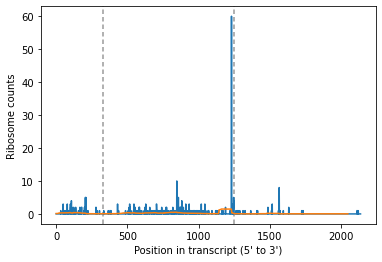

In [54]:
import numpy

# 30-codon sliding window average
window = numpy.ones(90).astype(float)/90.0
sliding_window_avg = numpy.convolve(my_vector_Fmr1,window,mode="valid")


# plot
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(my_vector_Fmr1,label="%s counts" % my_transcript.get_name())
plt.plot(sliding_window_avg,label="30 codon average")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("Ribosome counts")

# add outlines at start & stop codons
plt.axvline(my_transcript.cds_start,color="#999999",dashes=[3,2],zorder=-1)
plt.axvline(my_transcript.cds_end,color="#999999",dashes=[3,2],zorder=-1)

transcript position 1230 to 1233 corresponds to the pause site for Xbp1. 

In [61]:
my_vector_control[1228:1235]

array([ 0.,  0., 15., 17., 21.,  0.,  0.])

In [66]:
my_transcript.cds_start

328

In [72]:
my_transcript.get_sequence()

<function Transcript.get_sequence>

Ok, there is clearly way too much data in this GTF file and I need to find the specific set of the GTF file that is useful to me, at the moment it just gives me everything in a fly that ever was. 

Hmmmm, I definitely need to pick genes that have a decent number of reads in order to see anything. 

Do you think there is such thing as an average count array? I am just trying to figure out how we work multiple samples into this kind of analyses smoothly. 